# ph21: HWK 1
In this assignment, we will get Buoy data from the NDBC and then use it to make some estimates about the future.

### Familiarize yourself

We will be using data from the National Data Buoy Center (NDBC). Visit the NDBC website, https://www.ndbc.noaa.gov, and access some historical data. Take a look at the URL for the data you have accessed: you will need this format to access the data from python.

### Part 1: Getting the data

You will need to save all necessary for your second part here. The following steps are for reference.

1. Use the `requests` library (or any other similar library at your choice) to download historical Buoy data
3. Save all data you downloaded into (a) file(s). If you feel like it, only save that part that is relevant for your second part.
4. Use a html parser library (e.g., `BeautifulSoup`, `lxml`, or `html5lib`) to extract the meaning of the data (i.e. what is it measuring and what are the units?). Also save this information somewhere.
5. From now on, you don't need to make any more requests to the NDBC website. Only use the data you downloaded.


### Part 2: Processing the data
6. (Optional) use the `pandas` library to read the data and process as needed, and save the processed data if you want to. Save the processed data
7. plot the oceant temperatures (`WTMP`), wave heights (`WVHT`), average wave periods (`APD`), and wind speeds (`WSPD`) going back 10 years or so (some buoys don't have all the data every year)
8. Look through `scipy.stats` and choose something like Pearson's or Spearman's correlation test. Determine what (if any) correlations you find between mean ocean temperatures and maximum wave heights or wave periods.


### All written codes are only here for reference. You can also modify them if you want to.

# Part 1

In [1]:
# Libraries you might want to use
# Uncomment the ones you need
# from datetime import datetime
from io import StringIO
from pathlib import Path

from requests import Session
# from curl_cffi.requests import Session, AsyncSession

# from bs4 import BeautifulSoup
# from lxml import html

# from matplotlib import pyplot as plt
# import seaborn as sns

import pandas as pd
# import numpy as np
# from scipy import stats

import yaml
from tqdm import tqdm

In [ ]:
# Prepare requests session. Let's pretend we are Chrome 118 here

# Think: In some cases, we can still be blocked as been flagged as bot at the first request.
#        Can you guess how the server knows it? (ignore javascript for now)

sess = Session()
sess.headers.update({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'})

# Think: What's the difference between using requests.get() and sess.get()?

In [ ]:
# Where to save the fetched data
path = Path('./Data')
path.mkdir(exist_ok=True)
url_template = 'https://www.ndbc.noaa.gov/view_text_file.php?filename={buoy_id}h{year}.txt.gz&dir=data/historical/stdmet/'
description_page_url = 'https://www.ndbc.noaa.gov/faq/measdes.shtml'

In [ ]:
# Load the config file
with open('config.yaml') as f:
    config = yaml.safe_load(f)

buoy_ids:list[int] = config['buoys'] # We only use these id's for this assignment
columns:list[str] = config['columns'] # Data columns we want to keep. You may add more if you want

To fetch one file, you can do something like this:

In [ ]:
# An example of how to fetch the description and put it in a pd.DataFrame

r = sess.get(url_template.format(buoy_id=41010, year=2022))
r.raise_for_status()
buf= StringIO(r.text)
df = pd.read_csv(buf, delim_whitespace=True, skiprows=[1])

Take a look:

In [ ]:
df.head()

Now, your task here is:
1. For each buoy_id, generate all urls pointing to its data, and fetch&save the data. If the data is missing (`status_code`=404), skip it.
2. Save everything in raw, or any processed form that you see fits.
3. If the file is already downloaded, don't download it again. Just skip it here.

Learn more about http status codes here:
- https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
- https://http.cat/

Two important ones here for today:
- 200: OK; everything's alright
- 404: Not Found; the file is missing

In [ ]:
from pathlib import Path
from io import StringIO
import pandas as pd
import yaml
from requests import Session
from tqdm import tqdm

# Define path and create directory if needed
path = Path("./Data")
path.mkdir(exist_ok=True)

sess = Session()
sess.headers.update({
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
    )
})

# Load config
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

buoy_ids = config["buoys"]    
columns = config["columns"]   

# URLs
url_template = "https://www.ndbc.noaa.gov/view_text_file.php?filename={buoy_id}h{year}.txt.gz&dir=data/historical/stdmet/"
description_page_url = "https://www.ndbc.noaa.gov/faq/measdes.shtml"

# Fetch the measurement descriptions (saved as measdes.html)
desc_file_path = path / "measdes.html"
if not desc_file_path.exists():
    print("Fetching measurement descriptions from NDBC...")
    r_desc = sess.get(description_page_url)
    r_desc.raise_for_status()
    desc_file_path.write_text(r_desc.text, encoding="utf-8")
    print(f"Saved description page to {desc_file_path}")
else:
    print("Description page already downloaded. Skipping...")

# Fetch historical data
start_year = 2013
end_year   = 2023

print("\nFetching buoy data...")
for buoy_id in tqdm(buoy_ids, desc="Buoys"):
    for year in range(start_year, end_year + 1):
        filename = f"{buoy_id}h{year}.txt"
        file_path = path / filename
        if file_path.exists():
            continue

        file_url = url_template.format(buoy_id=buoy_id, year=year)
        resp = sess.get(file_url)
        if resp.status_code == 404:
            continue
        resp.raise_for_status()

        file_path.write_text(resp.text, encoding="utf-8")

print("\nDone fetching data!")

Description page already downloaded. Skipping...

Fetching buoy data...


Buoys: 100%|██████████| 11/11 [00:00<00:00, 19.77it/s]


Done fetching data!


Though the units for all quantities are included in the data files received already, lets also try get them again from the website along with the description for each columns by parsing htmls.

All information of our interest is available at [`description_page`](https://www.ndbc.noaa.gov/faq/measdes.shtml#stdmet).

Your task is to:

1. Get a dictionary of all the quantity name and its unit
2. Get a dictionary of all the quantity name and its description

To achieve this, you may want to use some html parser library, such as `BeautifulSoup`, `lxml`, or `html5lib`. If you really feel like it, you can also use regex just for fun like the good old days.

Tip: Having no idea where to start? Try to open the [`description_page`](https://www.ndbc.noaa.gov/faq/measdes.shtml#stdmet) in your browser, and use the `inspect` tool (F12, or Ctrl+Shift+I) to see how the html is structured and locate the part of your interest. Pasting a copy of the html to some LLM and ask it how to extract the information you want may also be a good idea.

Another Tip: Something called [`xpath`](https://en.wikipedia.org/wiki/XPath) may be extremely useful here. It can be access with `lxml`.

In [ ]:
r = sess.get(description_page_url)
r.raise_for_status()
html_text = r.text 

In [ ]:
# ================ INSERT YOUR CODE HERE ================

if not (path/'units.yaml').exists() or not (path/'meanings.yaml').exists():
    ...

    with open(path/'units.yaml', 'w') as f:
        yaml.dump(unit_map, f)
    with open(path/'meanings.yaml', 'w') as f:
        yaml.dump(meaning_map, f)

In [ ]:
with open(path/'units.yaml') as f:
    unit_map = yaml.safe_load(f)
unit_map

In [ ]:
with open(path/'meanings.yaml') as f:
    meaning_map = yaml.safe_load(f)
meaning_map

You may want to concatenate each buoy's data into a single dataframe, or any other data structure that you see fit. `pandas` is recommended here for your convenience.

After plotting, you will notice that some values are saturated at ~100. This is considered as artifacts, and should be removed. We will filter out everything $\ge 90$ in this case. If you are using `pandas`, you can do something like `df[df[columns] < 90]`.
Also, remove all rows with `NaN` values.

In [50]:
import re
import yaml
from pathlib import Path
from bs4 import BeautifulSoup

data_path = Path("./Data")
desc_file_path = data_path / "measdes.html"

units_yaml_path = data_path / "units.yaml"
meanings_yaml_path = data_path / "meanings.yaml"


# Read the file
with open(desc_file_path, "r", encoding="utf-8") as f:
    html_text = f.read()

soup = BeautifulSoup(html_text, "html.parser")

# Select all <dt> elements inside <dl.meas-des-glossary>
dt_tags = soup.select("dl.meas-des-glossary dt.meas-des-term")
print(f"Found {len(dt_tags)} <dt> tags in .meas-des-glossary blocks.")

# For each <dt>, find the next <dd> that has class="meas-des-meaning"
unit_map = {}
meaning_map = {}

for dt_tag in dt_tags:
    param = dt_tag.get_text(strip=True)  
    dd_tag = dt_tag.find_next("dd", class_="meas-des-meaning")
    
    if not dd_tag:
        continue
    
    desc = dd_tag.get_text(strip=True)
    
    
    match = re.search(r"\(([^()]+)\)", desc)
    if match:
        guessed_unit = match.group(1).strip()
    else:
        guessed_unit = None
    
    
    # Store results in the dictionaries
    
    unit_map[param] = guessed_unit
    meaning_map[param] = desc

# Write out to .yaml
with open(units_yaml_path, "w", encoding="utf-8") as f:
    yaml.dump(unit_map, f, allow_unicode=True)
with open(meanings_yaml_path, "w", encoding="utf-8") as f:
    yaml.dump(meaning_map, f, allow_unicode=True)

# Reload & Print
with open(units_yaml_path, "r", encoding="utf-8") as f:
    final_unit_map = yaml.safe_load(f) or {}
with open(meanings_yaml_path, "r", encoding="utf-8") as f:
    final_meaning_map = yaml.safe_load(f) or {}

print("\n== Unit Map ==")
for k,v in final_unit_map.items():
    print(f"{k} => {v}")

print("\n== Meaning Map ==")
for k,v in final_meaning_map.items():
    print(f"{k} => {v}")


Found 112 <dt> tags in .meas-des-glossary blocks.

== Unit Map ==
 => f,A
%Good3 => None
%Good4 => None
%GoodE => None
10-Minute Rain Rate => None
24-Hour Rain Rate => None
APD => seconds
ATMP => Celsius
AVP => None
BARO => None
BATTCURR => amperes
BATTTEMP => degrees Celsius
BATTV => volts
Bin => None
CHILL => None
CM1, CM2, CM3, CM4 => None
Chlorophyll Concentration (CLCON) => ug/l
Conductivity (COND) => None
DEP01, DEP02, ... => None
DEWP => None
DIR => None
DIR01, DIR02, ... => None
DOMPD => None
DPD => seconds
Depth => None
Depth (DEPTH) => meters
Dir => None
Directional Wave Spectrum => f
EI1, EI2, EI3, EI4 => None
Eh (EH) => oxidation and reduction
ErrVl => None
Flag => None
Flags => BIT
GDR => None
GMN => None
GSP => None
GST => None
GTIME => None
H0 => None
HEAT => None
HEIGHT => None
Highest 1 minute wind speed => hour and minute
Hourly Rain Accumulation => None
ICE => None
Instrument Number => None
LAT => None
LON => None
LRAD => None
LRAD1 => None
Longwave Radiation (LWRAD)

As python handles datetime objects in fundamentally nasty way, we provide a snippet to convert YMDhm to datetime objects for you. You can use it like this:

```python
YMDhm = df[['#YY','MM','DD','hh','mm']]
timestemp = YMDhm.agg(lambda x: datetime(*x), axis=1)
```

to get a series of datetime objects from the dataframe `df` with columns `#YY`, `MM`, `DD`, `hh`, and `mm`.

#### For one buoy, plot all of its columns from all last 10 years. You can use any plotter of your choice.
##### Can you see any trend? If it is too noisy for human eyes, what could to be done to make it more clear?

##### Launch `scipy.stats` and choose something like Pearson's or Spearman's correlation test. Determine what (if any) correlations you find between mean ocean temperatures and maximum wave heights or wave periods.|

Reading and concatenating buoy data...

Successfully read: 41002h2013.txt with 8716 records.
Successfully read: 41002h2014.txt with 7105 records.
Successfully read: 41002h2015.txt with 8725 records.
Successfully read: 41002h2016.txt with 8726 records.
Successfully read: 41002h2017.txt with 8701 records.
Successfully read: 41002h2018.txt with 40133 records.
Successfully read: 41002h2019.txt with 50102 records.
Successfully read: 41002h2020.txt with 40009 records.
Successfully read: 41002h2021.txt with 29766 records.
Successfully read: 41002h2022.txt with 52530 records.
File not found: Data\41004h2013.txt
Successfully read: 41004h2014.txt with 6061 records.
Successfully read: 41004h2015.txt with 8743 records.
Successfully read: 41004h2016.txt with 8739 records.
Successfully read: 41004h2017.txt with 39163 records.
Successfully read: 41004h2018.txt with 52357 records.
Successfully read: 41004h2019.txt with 52076 records.
Successfully read: 41004h2020.txt with 51934 records.
Successfully r

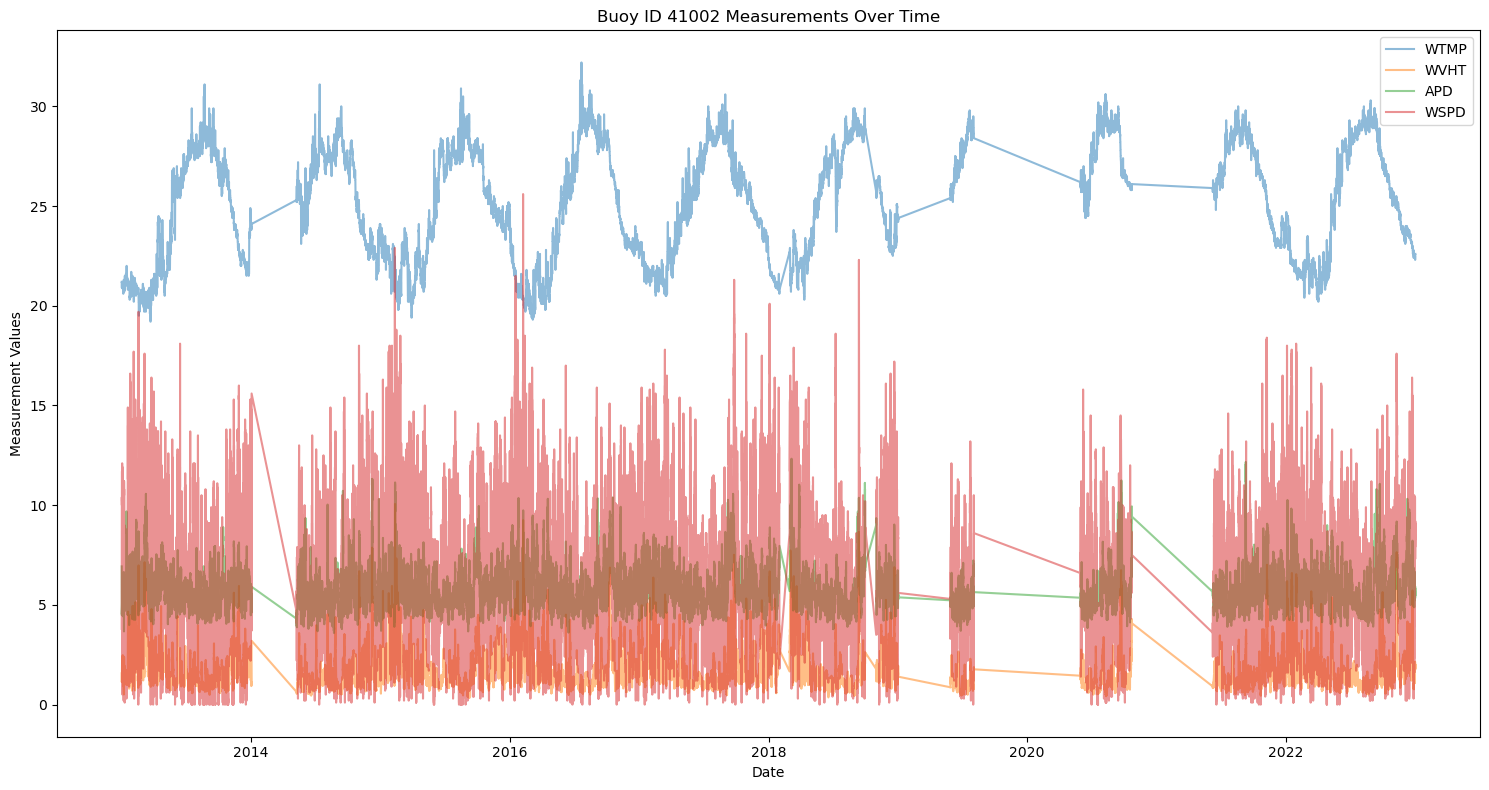

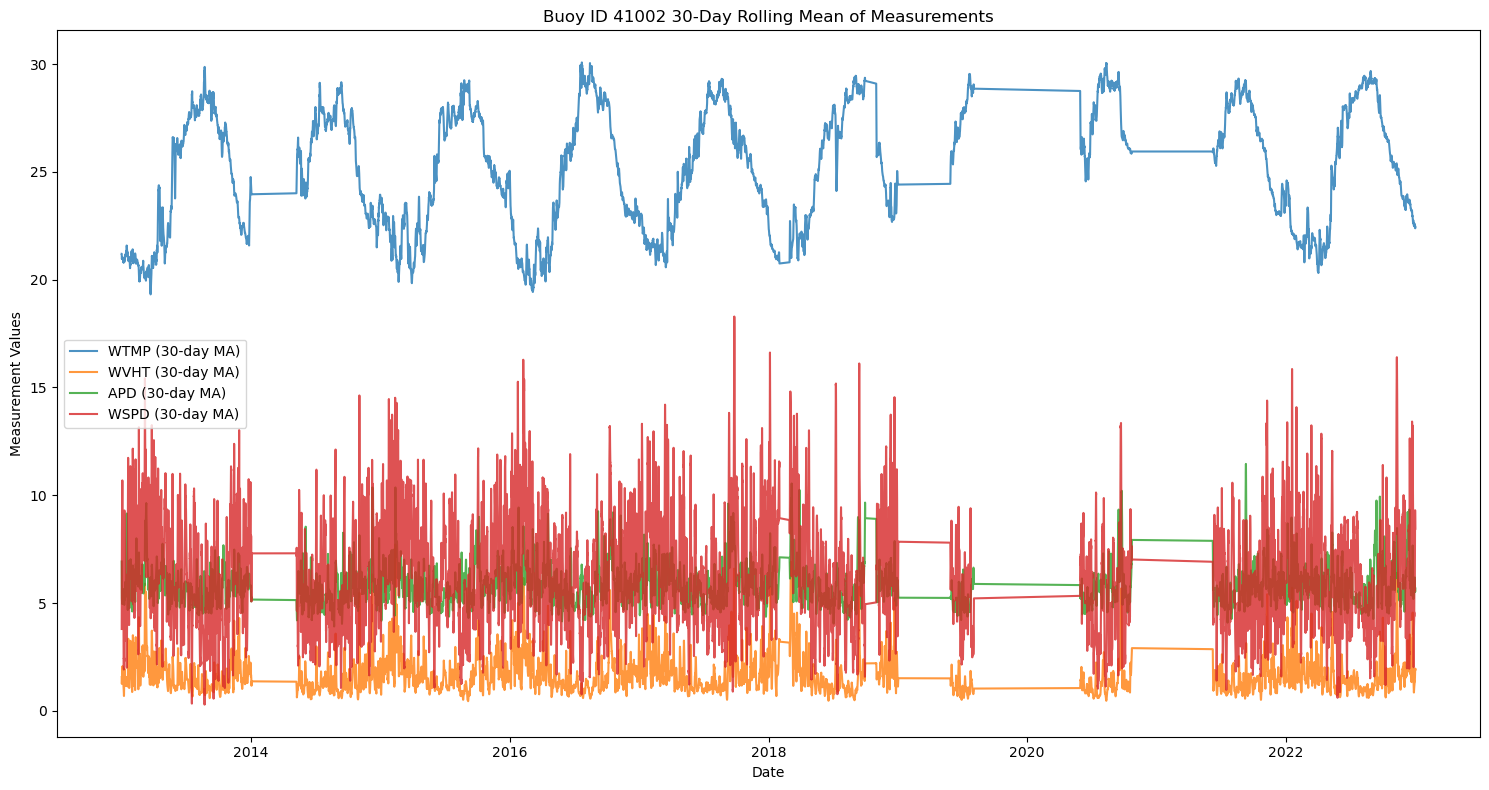


Performing Correlation Analysis...

=== Pearson Correlation Matrix ===
          WTMP      WVHT       APD      WSPD
WTMP  1.000000 -0.366679 -0.183459 -0.308260
WVHT -0.366679  1.000000  0.627019  0.654698
APD  -0.183459  0.627019  1.000000 -0.009325
WSPD -0.308260  0.654698 -0.009325  1.000000

=== Spearman Correlation Matrix ===
          WTMP      WVHT       APD      WSPD
WTMP  1.000000 -0.432368 -0.214776 -0.305485
WVHT -0.432368  1.000000  0.531525  0.622631
APD  -0.214776  0.531525  1.000000 -0.096239
WSPD -0.305485  0.622631 -0.096239  1.000000

Pearson Correlation between WTMP and WVHT: r = -0.367, p-value = 0.000e+00
Spearman Correlation between WTMP and APD: r = -0.215, p-value = 0.000e+00


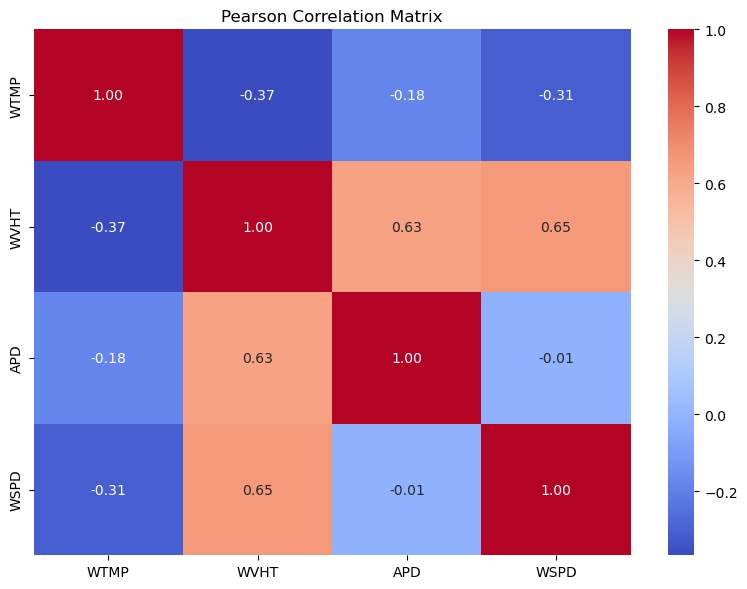

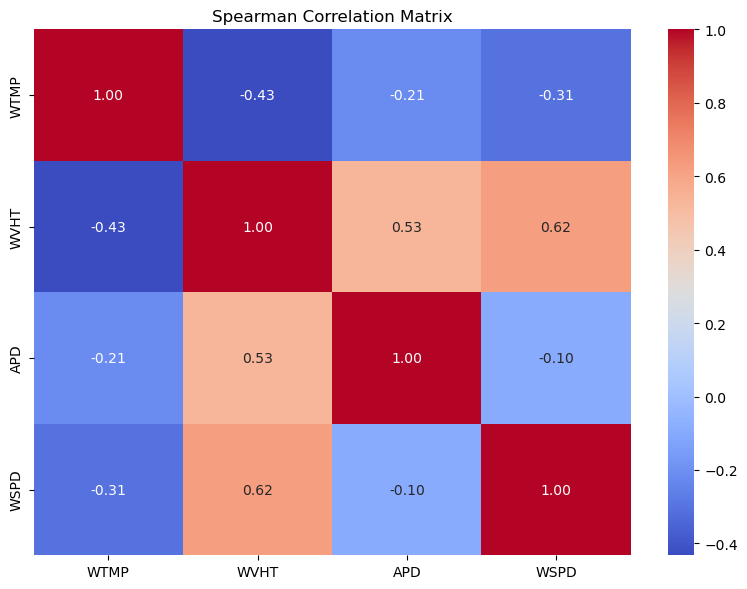

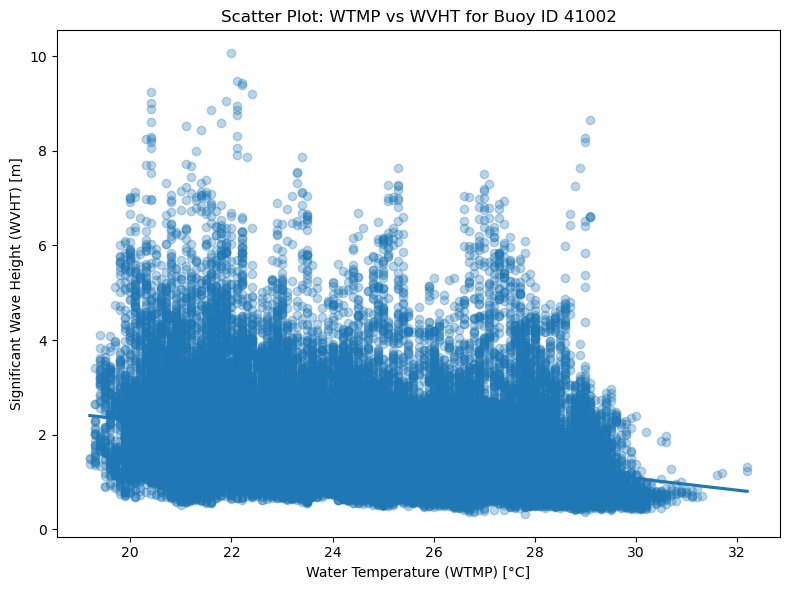

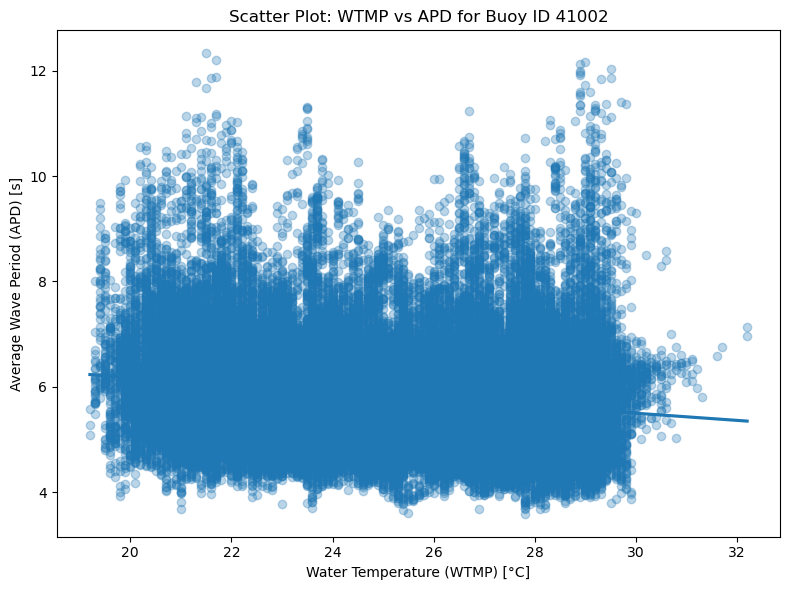

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

pd.options.mode.chained_assignment = None  

# Setup Paths and Configuration
data_path = Path("./Data")  

# Define the list of buoy IDs to process
buoy_ids = ["41002", "41004", "41008", "41009", "41013", "41047", 
            "42002", "42019", "42036", "42040", "42055"]

# Define the range of years to process
start_year = 2013
end_year = 2022

# Define Correct Column Names Based on Data Structure
column_names = [
    "YY",     # Year
    "MM",     # Month
    "DD",     # Day
    "hh",     # Hour
    "mm",     # Minute
    "WDIR",   # Wind Direction
    "WSPD",   # Wind Speed
    "GST",    # Gust Speed
    "WVHT",   # Significant Wave Height
    "DPD",    # Dominant Wave Period
    "APD",    # Average Wave Period
    "MWD",    # Mean Wave Direction
    "PRES",   # Atmospheric Pressure
    "ATMP",   # Air Temperature
    "WTMP",   # Water Temperature
    "DEWP",   # Dew Point Temperature
    "VIS",    # Visibility
    "TIDE"    # Tide Level
]


print("Reading and concatenating buoy data...\n")

all_dataframes = []

# Iterate through each buoy and each year to read data
for buoy_id in buoy_ids:
    for year in range(start_year, end_year + 1):
        filename = f"{buoy_id}h{year}.txt"
        file_path = data_path / filename
        if not file_path.exists():
            print(f"File not found: {file_path}")
            continue

        try:
            
            df = pd.read_csv(
                file_path,
                sep=r"\s+",           
                skiprows=2,            
                header=None,           
                names=column_names,    
                na_values=['999.0', '99.0', 'MM', 'N/A']  
            )

            df["BUOY_ID"] = str(buoy_id).strip()

            all_dataframes.append(df)
            print(f"Successfully read: {filename} with {len(df)} records.")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

if all_dataframes:
    df_all = pd.concat(all_dataframes, ignore_index=True)
    print(f"\nCombined DataFrame shape: {df_all.shape}")
    print("Sample DataFrame:")
    print(df_all.head())
else:
    print("No dataframes were read. Please check your data files.")
    df_all = pd.DataFrame()  

# Proceed Only If DataFrame Is Not Empty
if not df_all.empty:
    cols_of_interest = ["WTMP", "WVHT", "APD", "WSPD"]

    df_all[cols_of_interest] = df_all[cols_of_interest].apply(pd.to_numeric, errors='coerce')

    unique_buoys = df_all['BUOY_ID'].unique()
    print("\nUnique Buoy IDs in DataFrame:", unique_buoys)

    records_before = df_all[df_all['BUOY_ID'] == '41002'].shape[0]
    print(f"Number of records for Buoy ID 41002 before filtering: {records_before}")

    filtering_thresholds = {
        "WTMP": 35,  # Celsius
        "WVHT": 30,  # meters
        "APD": 60,    # seconds
        "WSPD": 50    # meters/second
    }

    for col, threshold in filtering_thresholds.items():
        if col in df_all.columns:
            initial_count = len(df_all)
            df_all = df_all[df_all[col] < threshold]
            print(f"Filtered {initial_count - len(df_all)} rows where {col} >= {threshold}")

    # Drop rows that have NaN in the columns of interest
    initial_count = len(df_all)
    df_all = df_all.dropna(subset=cols_of_interest)
    print(f"Dropped {initial_count - len(df_all)} rows with NaN in {cols_of_interest}")

    # Check number of records for Buoy ID 41002 after filtering
    records_after = df_all[df_all['BUOY_ID'] == '41002'].shape[0]
    print(f"Number of records for Buoy ID 41002 after filtering: {records_after}")

    if records_after > 0:
        print("Data for Buoy ID 41002 is available for analysis.\n")
    else:
        print("No data found for Buoy ID 41002 after filtering.\n")

    # Proceed with Plotting and Analysis for Buoy ID 41002
    if records_after > 0:
        selected_buoy = "41002"
        buoy_data = df_all[df_all["BUOY_ID"] == selected_buoy].copy()
        print(f"Selected Buoy ID for Analysis: {selected_buoy}")
        print(f"Number of records for Buoy ID {selected_buoy}: {len(buoy_data)}\n")

        buoy_data.rename(columns={'YY': 'year', 'MM': 'month', 'DD': 'day', 
                                  'hh': 'hour', 'mm': 'minute'}, inplace=True)

        buoy_data['year'] = buoy_data['year'].apply(lambda x: x if x >= 1000 else x + 2000)

        try:
            buoy_data["timestamp"] = pd.to_datetime(
                buoy_data[['year', 'month', 'day', 'hour', 'minute']],
                format="%Y %m %d %H %M",
                errors="coerce"
            )
            print("Datetime conversion successful.\n")
        except Exception as e:
            print(f"Error during datetime conversion: {e}\n")

        invalid_timestamps = buoy_data[buoy_data['timestamp'].isnull()]
        print(f"Number of rows with invalid datetime after conversion: {len(invalid_timestamps)}")

        # Drop rows with invalid datetime
        if not invalid_timestamps.empty:
            buoy_data = buoy_data.drop(invalid_timestamps.index)
            print(f"Dropped {len(invalid_timestamps)} rows with invalid datetime. New shape: {buoy_data.shape}\n")
        else:
            print("All datetime conversions are valid.\n")

        # Set 'timestamp' as index for plotting
        buoy_data.set_index("timestamp", inplace=True)

        plot_cols = ["WTMP", "WVHT", "APD", "WSPD"]

        # Plot All Columns Over Time
        plt.figure(figsize=(15, 8))
        for col in plot_cols:
            plt.plot(buoy_data.index, buoy_data[col], label=col, alpha=0.5)
        plt.title(f"Buoy ID {selected_buoy} Measurements Over Time")
        plt.xlabel("Date")
        plt.ylabel("Measurement Values")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Apply Rolling Mean to Smooth Data
        buoy_data_rolling = buoy_data[plot_cols].rolling(window=30, min_periods=1).mean()

        plt.figure(figsize=(15, 8))
        for col in plot_cols:
            plt.plot(buoy_data_rolling.index, buoy_data_rolling[col], label=f"{col} (30-day MA)", alpha=0.8)
        plt.title(f"Buoy ID {selected_buoy} 30-Day Rolling Mean of Measurements")
        plt.xlabel("Date")
        plt.ylabel("Measurement Values")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Correlation Analysis
        correlation_data = buoy_data[plot_cols].dropna()
        print("\nPerforming Correlation Analysis...")

        if not correlation_data.empty:
            # Pearson Correlation Matrix
            pearson_corr_matrix = correlation_data.corr(method='pearson')
            print("\n=== Pearson Correlation Matrix ===")
            print(pearson_corr_matrix)

            # Spearman Correlation Matrix
            spearman_corr_matrix = correlation_data.corr(method='spearman')
            print("\n=== Spearman Correlation Matrix ===")
            print(spearman_corr_matrix)

            # Pearson correlation between WTMP and WVHT
            if {"WTMP", "WVHT"}.issubset(correlation_data.columns):
                r_pearson, p_pearson = stats.pearsonr(correlation_data["WTMP"], correlation_data["WVHT"])
                print(f"\nPearson Correlation between WTMP and WVHT: r = {r_pearson:.3f}, p-value = {p_pearson:.3e}")

            # Spearman correlation between WTMP and APD
            if {"WTMP", "APD"}.issubset(correlation_data.columns):
                r_spearman, p_spearman = stats.spearmanr(correlation_data["WTMP"], correlation_data["APD"])
                print(f"Spearman Correlation between WTMP and APD: r = {r_spearman:.3f}, p-value = {p_spearman:.3e}")

           
            plt.figure(figsize=(8, 6))
            sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Pearson Correlation Matrix")
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(8, 6))
            sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Spearman Correlation Matrix")
            plt.tight_layout()
            plt.show()

            if {"WTMP", "WVHT"}.issubset(correlation_data.columns):
                plt.figure(figsize=(8, 6))
                sns.regplot(x='WTMP', y='WVHT', data=correlation_data, scatter_kws={'alpha':0.3})
                plt.title(f"Scatter Plot: WTMP vs WVHT for Buoy ID {selected_buoy}")
                plt.xlabel("Water Temperature (WTMP) [°C]")
                plt.ylabel("Significant Wave Height (WVHT) [m]")
                plt.tight_layout()
                plt.show()

            if {"WTMP", "APD"}.issubset(correlation_data.columns):
                plt.figure(figsize=(8, 6))
                sns.regplot(x='WTMP', y='APD', data=correlation_data, scatter_kws={'alpha':0.3})
                plt.title(f"Scatter Plot: WTMP vs APD for Buoy ID {selected_buoy}")
                plt.xlabel("Water Temperature (WTMP) [°C]")
                plt.ylabel("Average Wave Period (APD) [s]")
                plt.tight_layout()
                plt.show()
        else:
            print("No data available for correlation analysis after filtering.")
    else:
        print("Skipping plotting and analysis as no data found for Buoy ID 41002 after filtering.")
else:
    print("No data available after concatenation. Please check your data files.")



Scatter Plot Analysis (WTMP vs APD, WTMP vs WVHT):

* There is a noticeable spread in the scatter plots with no clear linear relationship between Water Temperature (WTMP) and Wave Period (APD) or Wave Height (WVHT).
* The trend lines slightly decrease, indicating a weak negative correlation between water temperature and these wave parameters.


The rolling averages for WTMP, WVHT, APD, and WSPD show seasonal patterns:
* WTMP (Water Temperature) displays a clear sinusoidal trend, representing seasonal temperature variations.
* WVHT (Wave Height) and WSPD (Wind Speed) have peaks likely corresponding to storm seasons or higher wave activity periods.
* APD (Average Wave Period) remains relatively stable compared to the other metrics.

The correlation matrices show:
* A moderate positive correlation between WVHT and APD.
* Weak to moderate negative correlations between WTMP and wave-related metrics (WVHT, APD, WSPD).

* The data is noisy and could benefit from employing longer rolling averages to highlight long-term trends.
Moreover, removing outliers or using more sophisticated outlier detection methods would be useful.

* Spearman's Rank Correlation suggests a monotonic relationship between variables, even if the relationship is not linear.
* Pearson's Correlation confirms weak to moderate linear correlations, especially between wave-related metrics.
